## Polytope Climate-DT AOI example notebook

This notebook shows how to use earthkit-data and earthkit-maps to pull destination-earth data from LUMI and plot it using earthkit-maps.

It also shows how to cut-out an area of interest using earthkit-transforms and perform some calculations upon that data.

Before running the notebook you need to set up your credentials. See the main readme of this repository for different ways to do this or use the following cells to authenticate.

You will need to generate your credentials using the desp-authentication.py script.

This can be run as follows:

In [ ]:
!python3 ~/polytope-examples/desp-authentication.py -u <user_name> -p <password>

This will generate a token that can then be used by earthkit and polytope.

You can also run the script without arguments to enter your username and password.

In [ ]:
!python3 ~/polytope-examples/desp-authentication.py 

# Requirements
To run this notebook install the following:
* pip install earthkit-data
* pip install earthkit-plots
* pip install earthkit-transforms
* pip install earthkit-regrid
* pip install cf-units         (Optional for unit conversion in plots)
* pip install matplotlib.pyplot

If you do not have eccodes installed please install eccodes using conda as it is a dependency of earthkit, or install earthkit via conda

* conda install eccodes -c conda-forge
* conda install earthkit-data -c conda-forge

In [ ]:
import earthkit.data
import earthkit.plots
import earthkit.regrid
from earthkit.transforms import aggregate as ek_aggregate

from earthkit.data.testing import earthkit_remote_test_data_file
import earthkit.plots.quickmap as qmap
import matplotlib.pyplot as plt

# This request matches multiple parameter of the climate DT

request = {
    'activity': 'ScenarioMIP',
    'class': 'd1',
    'dataset': 'climate-dt',
    'date': '20200102',
    'experiment': 'SSP3-7.0',
    'expver': '0001',
    'generation': '1',
    'levtype': 'sfc',
    'model': 'IFS-NEMO',
    'param': '134/165/166/167',
    'realization': '1',
    'resolution': 'standard',
    'stream': 'clte',
    'time': '0100', # '0100/0200/0300/0400/0500/0600'
    'type': 'fc'
}

#data is an earthkit streaming object but with stream=False will download data immediately 
data = earthkit.data.from_source("polytope", "destination-earth", request, address="polytope.lumi.apps.dte.destination-earth.eu", stream=False)


In [2]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,sp,surface,0,20200102,100,0,an,None,healpix
1,ecmf,10u,heightAboveGround,10,20200102,100,0,an,None,healpix
2,ecmf,10v,heightAboveGround,10,20200102,100,0,an,None,healpix
3,ecmf,2t,heightAboveGround,2,20200102,100,0,an,None,healpix


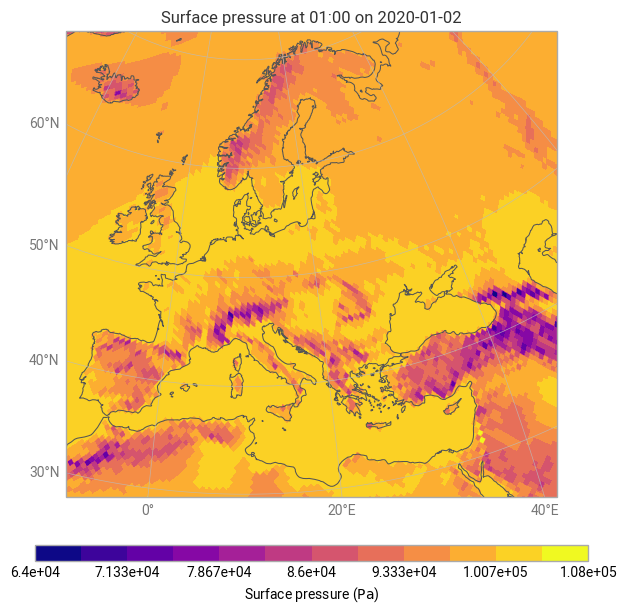

In [14]:
qmap.block(data[0], domain="Europe")

In [23]:
# Regrid t=from healpix for conversion to xarray
data_latlon = earthkit.regrid.interpolate(data, out_grid={"grid": [0.1,0.1]}, method="linear")
# Convert data to xarray
xarr = data_latlon[3].to_xarray(engine="cfgrib")
xarr

<xarray.Dataset> Size: 26MB
Dimensions:            (time: 1, step: 1, heightAboveGround: 1, latitude: 1801,
                        longitude: 3600)
Coordinates:
  * time               (time) datetime64[ns] 8B 2020-01-02T01:00:00
  * step               (step) timedelta64[ns] 8B 00:00:00
  * heightAboveGround  (heightAboveGround) float64 8B 2.0
  * latitude           (latitude) float64 14kB 90.0 89.9 89.8 ... -89.9 -90.0
  * longitude          (longitude) float64 29kB 0.0 0.1 0.2 ... 359.8 359.9
    valid_time         (time, step) datetime64[ns] 8B ...
Data variables:
    t2m                (time, step, heightAboveGround, latitude, longitude) float32 26MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          1003
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-26T08:57 GRIB to CDM+CF via cfgrib-0.9.1...

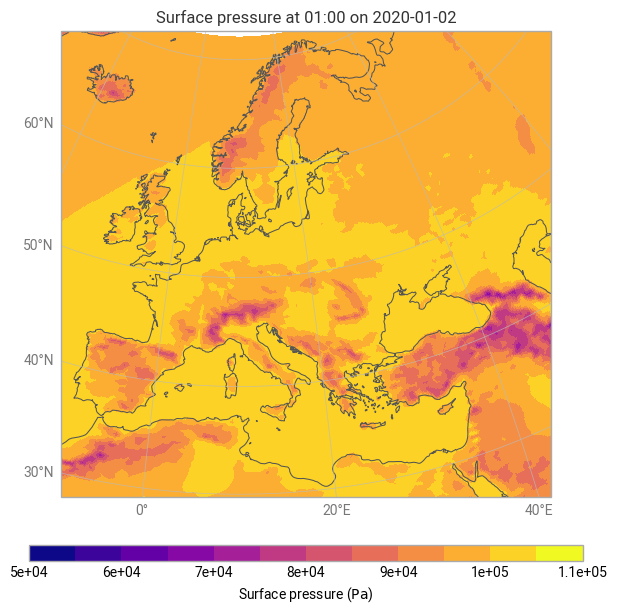

In [17]:
qmap.block(data_latlon[0], domain="Europe")

Here we pull shape files for masking of our area of interest

In [ ]:
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = earthkit.data.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

`spatial.mask` applies all the features in the geometry object (`nuts_data`) to the data object (`xarr`). It returns an xarray object the same shape and type as the input xarray object with all points outside of the geometry masked.

In [19]:
single_masked_data = ek_aggregate.spatial.mask(xarr, nuts_data)
single_masked_data

<xarray.Dataset> Size: 26MB
Dimensions:            (time: 1, step: 1, heightAboveGround: 1, latitude: 1801,
                        longitude: 3600)
Coordinates:
  * time               (time) datetime64[ns] 8B 2020-01-02T01:00:00
  * step               (step) timedelta64[ns] 8B 00:00:00
  * heightAboveGround  (heightAboveGround) float64 8B 2.0
  * latitude           (latitude) float64 14kB 90.0 89.9 89.8 ... -89.9 -90.0
  * longitude          (longitude) float64 29kB 0.0 0.1 0.2 ... 359.8 359.9
    valid_time         (time, step) datetime64[ns] 8B ...
Data variables:
    t2m                (time, step, heightAboveGround, latitude, longitude) float32 26MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          1003
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-26T08:55 GRIB to CDM+CF via cfgrib-0.9.1...

We can now plot the original data against our masked data

(35.0, 70.0)

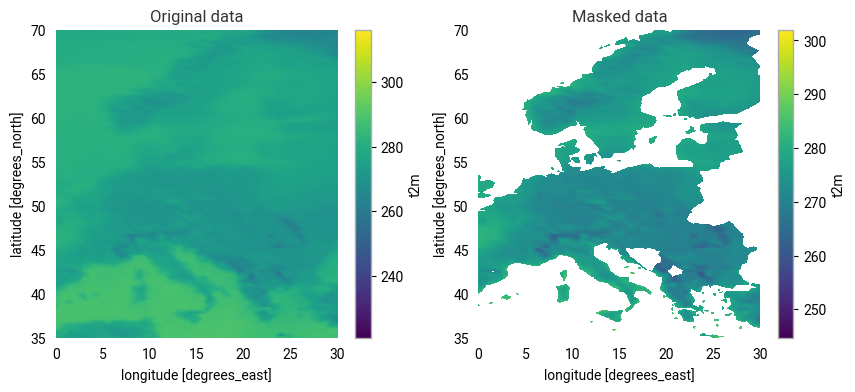

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
xarr.t2m.mean(dim='time').plot(ax=axes[0])
axes[0].set_title('Original data')
axes[0].set_xlim([0, 30])  # Longitude range for Europe
axes[0].set_ylim([35, 70])   # Latitude range for Europe
# Single masked data
single_masked_data.t2m.mean(dim='time').plot(ax=axes[1])
axes[1].set_title('Masked data')
axes[1].set_xlim([0, 30])  # Longitude range for Europe
axes[1].set_ylim([35, 70])   # Latitude range for Europe



We can further mask to only get the data for a given country.

In [21]:
masked_data = ek_aggregate.spatial.masks(xarr, nuts_data, mask_dim="FID")
masked_data

<xarray.Dataset> Size: 960MB
Dimensions:            (FID: 37, time: 1, step: 1, heightAboveGround: 1,
                        latitude: 1801, longitude: 3600)
Coordinates:
  * time               (time) datetime64[ns] 8B 2020-01-02T01:00:00
  * step               (step) timedelta64[ns] 8B 00:00:00
  * heightAboveGround  (heightAboveGround) float64 8B 2.0
  * latitude           (latitude) float64 14kB 90.0 89.9 89.8 ... -89.9 -90.0
  * longitude          (longitude) float64 29kB 0.0 0.1 0.2 ... 359.8 359.9
    valid_time         (time, step) datetime64[ns] 8B dask.array<chunksize=(1, 1), meta=np.ndarray>
  * FID                (FID) object 296B 'DK' 'RS' 'EE' 'EL' ... 'CZ' 'DE' 'NO'
Data variables:
    t2m                (FID, time, step, heightAboveGround, latitude, longitude) float32 960MB dask.array<chunksize=(1, 1, 1, 1, 1801, 3600), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          1003
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-11-26T08:55 GRIB to CDM+CF via cfgrib-0.9.1...

Here we only retrieve data for Germany, and plot.

Text(0.5, 1.0, 'Masked Germany Zoom')

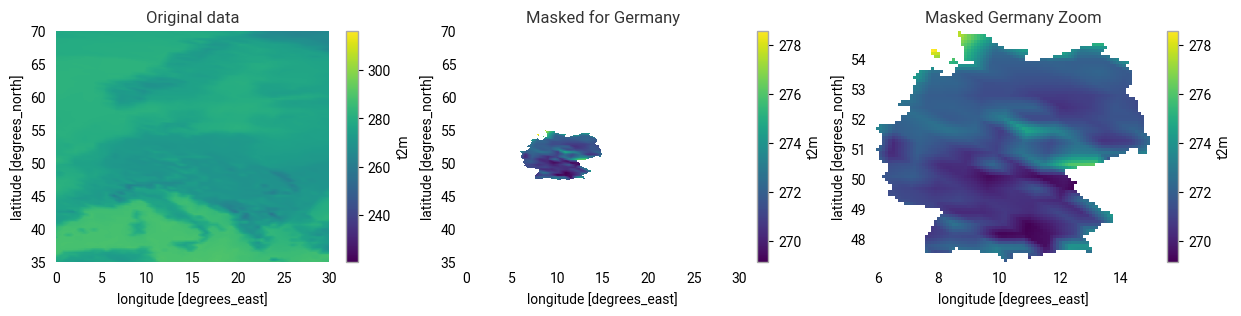

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15,3))
xarr.t2m.mean(dim='time').plot(ax=axes[0])
axes[0].set_title('Original data')
axes[0].set_xlim([0, 30])  # Longitude range for Europe
axes[0].set_ylim([35, 70])   # Latitude range for Europe
masked_data.t2m.sel(FID='DE').mean(dim='time').plot(ax=axes[1])
axes[1].set_title('Masked for Germany')
axes[1].set_xlim([0, 30])  # Longitude range for Europe
axes[1].set_ylim([35, 70])   # Latitude range for Europe
germany_data = masked_data.sel(FID='DE').dropna(dim='latitude', how='all').dropna(dim='longitude', how='all')
germany_data.t2m.mean(dim='time').plot(ax=axes[2])
axes[2].set_title('Masked Germany Zoom')
